# Machine Learning for the Dementia Prediction Project  
Goal: Develop a machine learning model to predict whether a new patient will have or develop dementia based on previous patients.  

Methodology:  
- Split data into training and testing sets  
- Test different machine learning models against each other to determine which has the highest accuracy
    - Knearest Neighbor
    - Decision Trees
    - Logistic Regression  
    - Support Vector Machine
- Choose one model then perform more rigorous analytics on that model

In [2]:
# import libraries
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
# get the data from the database
conn = sqlite3.connect("Dementia.db")                           # connect to the database
query = 'SELECT * FROM datawrangled'                   
data_ml = pd.read_sql(query, conn)                    # this will be the main dataframe used 

**Inputs:**  
The inputs are the features that are used to predict the outcome of the patients.  
Our inputs are M/F, Educ, SES and nWBV.  
Other features were not included in the model because ANOVA test showed that there was not a significant difference in groups.  
**Output:**  
We have three output options for this dataset: Group, MMSE, and CDR.  
Group is categorical, where as MMSE and CDR and continous variables.  
For the purpose of this analysis, Group will be used as a categorical variable for classification machine learning.  
The other two outcome may be anaylzed later. 

In [4]:
# Define X and Y variables, convert these values from a pandas dataframe into a numpy array
XX = data_ml[['M/F','EDUC','SES','nWBV']].values
y = data_ml['Group'].values

In [5]:
# Normalize data
# standardize the data in X then reassign it to the variable x
sc = preprocessing.StandardScaler()
sc.fit(XX)
X = sc.transform(XX.astype(float))

In [6]:
# split the data into training and testing sets, test_size = 0.2, random_state=2
X_train, X_test, Y_train, Y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (298, 4) (298,)
Test set: (75, 4) (75,)


### K Nearest Neighbor  
A method for classifying cases based on their similarity to other cases.  
K: Number of neighbors being considered

In [7]:
# create a KNN object
parameters = {'n_neighbors': range(2,16), # [2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15], ## consider replacing with range(2, 16)
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, cv=10)
knn_cv = grid_search.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.7245977011494253


In [8]:
yhat_knn = knn_cv.predict(X_test)

In [9]:
knn_accuracy = metrics.accuracy_score(Y_test, yhat_knn)
knn_accuracy

0.6533333333333333

### Decision Trees  
Splits the training test set into nodes and maps out all of the possible decision paths in the form of a tree

In [10]:
# create a decision tree object
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, parameters, cv=10)
tree_cv = grid_search.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.7318390804597701


In [11]:
# make predictions on test set
yhat_tree = tree_cv.predict(X_test)
# compare predictions to actual
print (yhat_tree [0:50])
print (Y_test [0:50])

['Nondemented' 'Nondemented' 'Demented' 'Nondemented' 'Nondemented'
 'Demented' 'Nondemented' 'Nondemented' 'Demented' 'Demented' 'Demented'
 'Demented' 'Nondemented' 'Nondemented' 'Nondemented' 'Nondemented'
 'Nondemented' 'Nondemented' 'Nondemented' 'Nondemented' 'Nondemented'
 'Demented' 'Nondemented' 'Demented' 'Nondemented' 'Demented' 'Demented'
 'Demented' 'Nondemented' 'Nondemented' 'Demented' 'Nondemented'
 'Nondemented' 'Demented' 'Nondemented' 'Demented' 'Nondemented'
 'Demented' 'Nondemented' 'Demented' 'Nondemented' 'Nondemented'
 'Nondemented' 'Demented' 'Nondemented' 'Demented' 'Demented'
 'Nondemented' 'Nondemented' 'Demented']
['Demented' 'Nondemented' 'Demented' 'Nondemented' 'Nondemented'
 'Demented' 'Demented' 'Nondemented' 'Nondemented' 'Demented' 'Demented'
 'Demented' 'Nondemented' 'Nondemented' 'Demented' 'Nondemented'
 'Nondemented' 'Demented' 'Nondemented' 'Demented' 'Nondemented'
 'Nondemented' 'Demented' 'Demented' 'Nondemented' 'Demented' 'Demented'
 'Nondem

In [12]:
# check accuracy of model
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(Y_test, yhat_tree))
tree_accuracy = metrics.accuracy_score(Y_test, yhat_tree)

DecisionTrees's Accuracy:  0.7466666666666667


### Logistic Regression
Logisitic regression provides the probability that the subject will belong to one of the groups

In [13]:
# create a logistic regression object
# create a grid search cv object with cv =10
# fit the object to find the parameters from the dictionary parameters
parameters ={'C':[0.001,0.01,0.1,1,10],
             'penalty':['l2'],
             'solver':['lbfgs', 'liblinear'],
             'multi_class':['ovr']}
lr=LogisticRegression()
grid_search = GridSearchCV(lr, parameters, cv=10)
logreg_cv = grid_search.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.6779310344827587


In [14]:
# predict using our test set
yhat_logreg = logreg_cv.predict(X_test)
yhat_logreg

array(['Demented', 'Nondemented', 'Nondemented', 'Nondemented',
       'Demented', 'Nondemented', 'Nondemented', 'Nondemented',
       'Nondemented', 'Nondemented', 'Demented', 'Nondemented',
       'Demented', 'Nondemented', 'Demented', 'Demented', 'Demented',
       'Demented', 'Nondemented', 'Demented', 'Demented', 'Demented',
       'Demented', 'Nondemented', 'Nondemented', 'Demented', 'Demented',
       'Nondemented', 'Demented', 'Demented', 'Demented', 'Nondemented',
       'Nondemented', 'Demented', 'Nondemented', 'Nondemented',
       'Nondemented', 'Nondemented', 'Demented', 'Demented',
       'Nondemented', 'Nondemented', 'Demented', 'Nondemented',
       'Nondemented', 'Demented', 'Demented', 'Nondemented',
       'Nondemented', 'Demented', 'Nondemented', 'Demented',
       'Nondemented', 'Nondemented', 'Nondemented', 'Nondemented',
       'Nondemented', 'Demented', 'Nondemented', 'Nondemented',
       'Nondemented', 'Nondemented', 'Demented', 'Demented',
       'Nondemented

In [15]:
yhat_prob = logreg_cv.predict_proba(X_test)
yhat_prob

array([[0.82716414, 0.17283586],
       [0.47244114, 0.52755886],
       [0.36480537, 0.63519463],
       [0.14656718, 0.85343282],
       [0.50435081, 0.49564919],
       [0.26457145, 0.73542855],
       [0.14311338, 0.85688662],
       [0.32085444, 0.67914556],
       [0.38594045, 0.61405955],
       [0.42943359, 0.57056641],
       [0.60471424, 0.39528576],
       [0.35709545, 0.64290455],
       [0.60621305, 0.39378695],
       [0.03659954, 0.96340046],
       [0.59672854, 0.40327146],
       [0.70946959, 0.29053041],
       [0.76829197, 0.23170803],
       [0.65783613, 0.34216387],
       [0.28310537, 0.71689463],
       [0.78028263, 0.21971737],
       [0.76925684, 0.23074316],
       [0.505717  , 0.494283  ],
       [0.671467  , 0.328533  ],
       [0.496032  , 0.503968  ],
       [0.18372342, 0.81627658],
       [0.76583446, 0.23416554],
       [0.50757722, 0.49242278],
       [0.39078757, 0.60921243],
       [0.73110733, 0.26889267],
       [0.78375786, 0.21624214],
       [0.

In [16]:
# calculate the accuracy using score
logreg_accuracy = metrics.accuracy_score(Y_test, yhat_logreg)

### Support Vector Machine  
Classifies cases by finding a seperator

In [17]:
# create a SVM object 
# create a grid search cv object with cv=10
parameters = {'kernel':('rbf', 'sigmoid'),
              'C': np.logspace(1, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC(decision_function_shape='ovr')
grid_search = GridSearchCV(svm, parameters, cv=5)
svm_cv = grid_search.fit(X_train, Y_train)

In [18]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}
accuracy : 0.7182485875706215


In [19]:
# use the model to predict values
yhat_svm = svm_cv.predict(X_test)
print(yhat_svm[0:70])
print (Y_test [0:70])

['Nondemented' 'Nondemented' 'Demented' 'Nondemented' 'Nondemented'
 'Demented' 'Nondemented' 'Nondemented' 'Nondemented' 'Demented'
 'Demented' 'Demented' 'Demented' 'Nondemented' 'Demented' 'Demented'
 'Demented' 'Nondemented' 'Nondemented' 'Nondemented' 'Demented'
 'Nondemented' 'Nondemented' 'Demented' 'Nondemented' 'Demented'
 'Nondemented' 'Nondemented' 'Nondemented' 'Nondemented' 'Demented'
 'Nondemented' 'Nondemented' 'Demented' 'Nondemented' 'Demented'
 'Nondemented' 'Nondemented' 'Demented' 'Demented' 'Nondemented'
 'Nondemented' 'Nondemented' 'Nondemented' 'Nondemented' 'Demented'
 'Demented' 'Nondemented' 'Nondemented' 'Demented' 'Demented' 'Demented'
 'Demented' 'Demented' 'Demented' 'Nondemented' 'Nondemented' 'Demented'
 'Nondemented' 'Nondemented' 'Nondemented' 'Nondemented' 'Demented'
 'Demented' 'Demented' 'Nondemented' 'Nondemented' 'Nondemented'
 'Nondemented' 'Nondemented']
['Demented' 'Nondemented' 'Demented' 'Nondemented' 'Nondemented'
 'Demented' 'Demented' 'Non

In [20]:
svm_accuracy = metrics.accuracy_score(Y_test, yhat_svm)
svm_accuracy

0.72

### Comparing the models

In [21]:
print("KNN Accuracy: ", knn_accuracy)
print("Decision Tree Accuracy: ", tree_accuracy)
print("Logistic Regression Accuracy: ", logreg_accuracy)
print("SVM Accuracy: ", svm_accuracy)

KNN Accuracy:  0.6533333333333333
Decision Tree Accuracy:  0.7466666666666667
Logistic Regression Accuracy:  0.6133333333333333
SVM Accuracy:  0.72


Conclusion: The K Nearest Neighbor model had the highest accuracy, but all four models were relatively similar.  
Perform more metrics to further compare the models.  

Methods of comparison:  
- Jaccard Index
- F1 Score
- Confusion Matrix
- Log Loss for Logistic Regression

In [22]:
# evaluate KNN with f1 score
knn_f1_score = f1_score(Y_test,yhat_knn, average = 'weighted')
# evaluate KNN with Jaccard Score
knn_jaccard_score = jaccard_score(Y_test, yhat_knn, average=None)

# evaluate with f1 score
tree_f1_score = f1_score(Y_test,yhat_tree, average = 'weighted')
# evaluate with Jaccard Score
tree_jaccard_score = jaccard_score(Y_test, yhat_tree,average=None)

# evaluate with f1 score
svm_f1_score = f1_score(Y_test,yhat_svm, average = 'weighted')
# evaluate with Jaccard Score
svm_jaccard_score = jaccard_score(Y_test, yhat_svm,average=None)

# evaluate with log loss
lr_log_loss=log_loss(Y_test, yhat_prob)
# evaluate with f1 score
lr_f1_score = f1_score(Y_test,yhat_logreg, average = 'weighted')
# evaluate with Jaccard Score
lr_jaccard_score = jaccard_score(Y_test,yhat_logreg,average=None)

# make a pretty table of the results
results = {'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'],
           'Jaccard':[knn_jaccard_score,tree_jaccard_score,svm_jaccard_score,lr_jaccard_score],
           'F1-score':[knn_f1_score,tree_f1_score,svm_f1_score,lr_f1_score],
           'LogLoss':['NA','NA','NA',lr_log_loss],
           'Accuracy Score':[knn_accuracy,tree_accuracy,svm_accuracy,logreg_accuracy]}
results_df = pd.DataFrame(data=results)
results_df

,Algorithm,Jaccard,F1-score,LogLoss,Accuracy Score
0,KNN,"[0.44680851063829785, 0.5185185185185185]",0.652463,NA,0.653333
1,Decision Tree,"[0.5581395348837209, 0.6274509803921569]",0.745573,NA,0.746667
2,SVM,"[0.5116279069767442, 0.6037735849056604]",0.717466,NA,0.720000
3,Logistic Regression,"[0.3958333333333333, 0.48214285714285715]",0.611665,0.622803,0.613333


In [25]:
# define function to plot the confusion matrix
def plot_confusion_matrix(y,y_predict,model):
    "this function plots the confusion matrix"
    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix {model}'); 
    ax.xaxis.set_ticklabels(['Demented','Nondemented']); ax.yaxis.set_ticklabels(['Demented','Nondemented'])

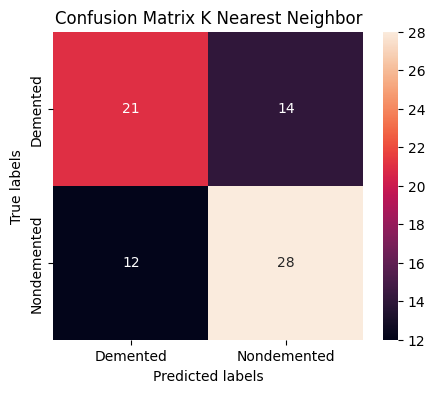

In [26]:
# plot confusion matrix for KNN
plot_confusion_matrix(Y_test,yhat_knn,"K Nearest Neighbor")

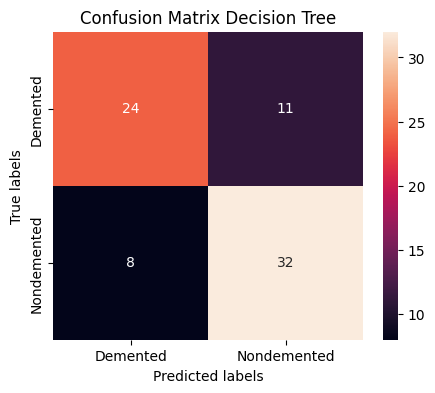

In [27]:
# plot confusion matrix for decision tree
plot_confusion_matrix(Y_test,yhat_tree,"Decision Tree")

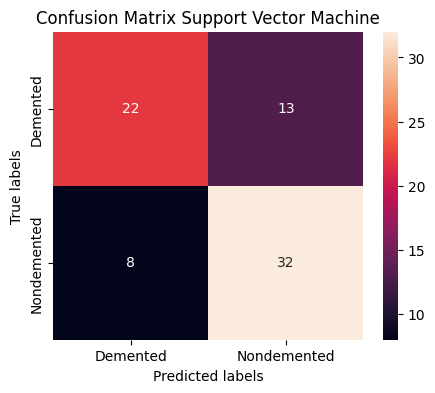

In [28]:
# plot confusion matrix for SVM
plot_confusion_matrix(Y_test,yhat_svm,"Support Vector Machine")

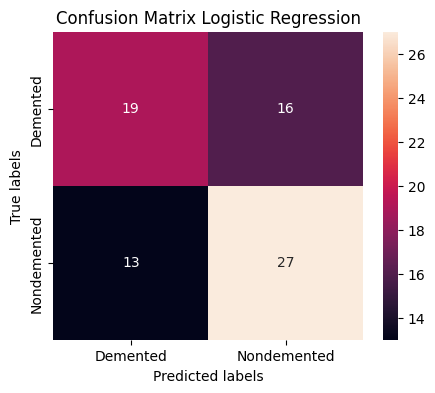

In [29]:
# plot confusion matrix for LR
plot_confusion_matrix(Y_test,yhat_logreg,"Logistic Regression")

### K Fold Cross Validation
Lets perform K fold cross validation to ensure the model isnt being overfit to the data

In [30]:
k = 5
kf = KFold(n_splits=k, random_state=None)
# get average accuracy for KNN
kfold_knn = cross_val_score(knn_cv, X, y, cv = kf)
print("Avg accuracy KNN: {}".format(kfold_knn.mean()))
# repeat for SVM
kfold_svm = cross_val_score(svm_cv, X, y, cv = kf)
print("Avg accuracy svm: {}".format(kfold_svm.mean()))
# repeat for LR
kfold_lr = cross_val_score(logreg_cv, X, y, cv = kf)
print("Avg accuracy logistic regression: {}".format(kfold_lr.mean()))
# repeat for tree
kfold_tree = cross_val_score(tree_cv, X, y, cv = kf)
print("Avg accuracy decision tree: {}".format(kfold_tree.mean()))

Avg accuracy KNN: 0.581981981981982
Avg accuracy svm: 0.6194594594594595
Avg accuracy logistic regression: 0.6380540540540541
Avg accuracy decision tree: 0.5631711711711712


### Conclusion:
The models all have their strengths and weaknesses.  
- Preliminary analysis showed that decision tree had one of the highest accuracies, however K fold cross validation revealed that this is due to overfitting of the model
- Logistic regression had the highest k fold cross validation score. However, this is a imbalanced dataset and therefore F1 score is a more important measure of performance than accuracy and the logistic regression model had a lower F1 score
- Support Vector Machine had high F1 score and high k fold cross validation. 
- K nearest neighbor preformed the worst in all aspects.  

Therefore, Support Vector Machine is decided to be the best model to move forward with.

In [31]:
# Export the ML model
import pickle
with open(r'svm_model.pickle', 'wb') as f:
    pickle.dump(svm_cv, f)